In [1]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce

import pose_2D as pose2d
import pose_3D as pose3d
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [83]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

In [3]:
torch.cuda.is_available()

True

In [4]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.current_device()

0

## 1- Load

In [6]:
inputs, labels = pkl.load(open( "data/TRAIN.pkl", "rb" ))

### b- Sample the large data

In [7]:
sample_size = 900000
sample_inputs, sample_labels = zip(*rand.sample(list(zip(inputs, labels)), 2*sample_size))

In [8]:
train_inputs = np.array(list(sample_inputs[:int(1.8*sample_size)]))
train_labels = np.array(list(sample_labels[:int(1.8*sample_size)]))
val_inputs = np.array(list(sample_inputs[int(1.8*sample_size):]))
val_labels = np.array(list(sample_labels[int(1.8*sample_size):]))

In [9]:
val_labels.shape

(180000, 9)

### c- add random input occlusion

In [10]:
def add_occlusion(pedestrian):
    dim = int(pedestrian.shape[0]/14)
    pedestrian = pedestrian.reshape((14,dim)).transpose()
    states = [ 'left wrist occluded', 'right wrist occluded', ]

## 2- create and prepare model

In [11]:
net = mlmodel.LinearModel(59, 9, num_stage=3)

In [12]:
net = net.to(device)

### a- prepare data loader and learning rate decay

In [13]:
class PrepareData(Dataset):
    def __init__(self, X, Y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()
        
        if not torch.is_tensor(Y):
            self.Y = torch.from_numpy(Y).float()
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [14]:
loss = nn.MSELoss()
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate

In [15]:
size_batches = 500
ds = PrepareData(X=train_inputs, Y=train_labels)

ds = DataLoader(ds, batch_size = size_batches, shuffle=True)



### b- infer data and find error between ground truth and prediction

In [16]:
def infer(inputs, model):
    with torch.no_grad():
        net = model
        net = net.to(device)
        net.eval()
        inputs = torch.from_numpy(inputs).float().to(device)
        outputs = net(inputs)
        outputs.cpu().detach().numpy()
    return outputs

In [17]:
def find_error(inputs, gt, model):
    pred = infer(inputs, model).cpu().numpy()
    return np.mean(np.linalg.norm(gt-pred, axis = 1))

## 3- Train

In [214]:
losses = []
for epoch in range(400):
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    e_loss = []
    for i, data in enumerate(ds, 0):
        batch_inputs, batch_labels = data
        (batch_inputs, batch_labels) = (batch_inputs.to(device), batch_labels.to(device))
        
        optimizer.zero_grad()
        
        batch_outputs = net(batch_inputs)
        
        l = loss(batch_outputs, batch_labels)
        
        l.backward()
        optimizer.step()
        
        e_loss.append(l)
    
    print(epoch, 'train loss:', find_error(train_inputs,train_labels, net),
          '\t val loss:', find_error(val_inputs,val_labels, net))
        
        

0 train loss: 0.6406104872446194 	 val loss: 0.6451273533247356
1 train loss: 0.6493130328529435 	 val loss: 0.6525440758515731
2 train loss: 0.6555589757260408 	 val loss: 0.6588941405543967
3 train loss: 0.5269432298335335 	 val loss: 0.5312269779167568
4 train loss: 0.5068978338289954 	 val loss: 0.5109195635856619
5 train loss: 0.5343532370899201 	 val loss: 0.5374869129805758
6 train loss: 0.4775093765755862 	 val loss: 0.4817131496431369
7 train loss: 0.5374351219702237 	 val loss: 0.5411103054442377
8 train loss: 0.4649756569607711 	 val loss: 0.46908712172395056
9 train loss: 0.5033352515757329 	 val loss: 0.5067336880616815
10 train loss: 0.5214729147336311 	 val loss: 0.5251213019601446
11 train loss: 0.4872787527978018 	 val loss: 0.49165413618886417
12 train loss: 0.4778018534716032 	 val loss: 0.48170285000633634
13 train loss: 0.5348867089549804 	 val loss: 0.53911007092533
14 train loss: 0.4619070267130405 	 val loss: 0.46643489864117016
15 train loss: 0.750809173338966 

125 train loss: 0.40826141427679336 	 val loss: 0.41586034311024683
126 train loss: 0.3433539549500445 	 val loss: 0.35092434907429715
127 train loss: 0.3377023786040051 	 val loss: 0.345253643015709
128 train loss: 0.3274992628704573 	 val loss: 0.3357639703991073
129 train loss: 0.32573459460800686 	 val loss: 0.3336152762785815
130 train loss: 0.36406508525558473 	 val loss: 0.3711429260750521
131 train loss: 0.3202696326681406 	 val loss: 0.328359083851484
132 train loss: 0.3268922425828808 	 val loss: 0.3349320123401467
133 train loss: 0.38043040051757016 	 val loss: 0.38832473946939894
134 train loss: 0.3466390714891018 	 val loss: 0.35444429912570485
135 train loss: 0.31825866504829 	 val loss: 0.32643334704286875
136 train loss: 0.3215706698871554 	 val loss: 0.3298580490882622
137 train loss: 0.34191379012539264 	 val loss: 0.35013938656651244
138 train loss: 0.3250271939989821 	 val loss: 0.33348452654748034
139 train loss: 0.35141921746051225 	 val loss: 0.3593478424919979
1

248 train loss: 0.3130191442017021 	 val loss: 0.33512442041839663
249 train loss: 0.3163042362910355 	 val loss: 0.3395105945357446
250 train loss: 0.3016801755667015 	 val loss: 0.32558942271927155
251 train loss: 0.3024741344436818 	 val loss: 0.3266550661649758
252 train loss: 0.2998949652345874 	 val loss: 0.32479594940762785
253 train loss: 0.29783222393609077 	 val loss: 0.32332409163410003
254 train loss: 0.3000198355492665 	 val loss: 0.3254380052239258
255 train loss: 0.31843374125209 	 val loss: 0.3432011549784174
256 train loss: 0.3021712994686067 	 val loss: 0.328492407512399
257 train loss: 0.29835954125352365 	 val loss: 0.3247461218537722
258 train loss: 0.30790628297497424 	 val loss: 0.3332188723934648
259 train loss: 0.29752826762551815 	 val loss: 0.32392607791486405
260 train loss: 0.30069030623586845 	 val loss: 0.32723925901379997
261 train loss: 0.3058426797125216 	 val loss: 0.33121429860765816
262 train loss: 0.33645707420779875 	 val loss: 0.36156415022673155

371 train loss: 0.2832873771221681 	 val loss: 0.34122665196648605
372 train loss: 0.28174311408068686 	 val loss: 0.3400858151786562
373 train loss: 0.2792229125835129 	 val loss: 0.33808321332570007
374 train loss: 0.28652493330957357 	 val loss: 0.3442407259131624
375 train loss: 0.28226898749499046 	 val loss: 0.34158478696949357
376 train loss: 0.279667343682939 	 val loss: 0.33980525210764334
377 train loss: 0.2805514348105941 	 val loss: 0.3407029282825805
378 train loss: 0.28763921873441767 	 val loss: 0.3456398291919694
379 train loss: 0.2822109225155401 	 val loss: 0.341522555066932
380 train loss: 0.28244005439262737 	 val loss: 0.34251393671750757
381 train loss: 0.3110804496228802 	 val loss: 0.3629282226908164
382 train loss: 0.2841728747762512 	 val loss: 0.34317988976967306
383 train loss: 0.27880843089783397 	 val loss: 0.3403607314182289
384 train loss: 0.2819340002131422 	 val loss: 0.34325507759578655
385 train loss: 0.2866856780921777 	 val loss: 0.3452919131309747

In [215]:
name = 'net-v0_3.pkl'
torch.save(net.state_dict(), name)

In [213]:
params = torch.load('net-v0_3.pkl')
net.load_state_dict(params)

<All keys matched successfully>

## 4- visualize a validation result

In [19]:
i = 100000
test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
gt = val_labels[i]
print(test)
print(gt)

[-1.5711672   0.7832403   0.06093463 -0.77294296 -0.00856937  0.5205933
  0.40956175  0.00958517  0.2664919 ]
[-1.57079633  0.78539816  0.         -0.78539816  0.          0.52359878
  0.43196899  0.          0.26179939]


In [20]:
props = inputs[i][42:]
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

In [21]:
body_props = dict(zip(list_body, props[:8]))
face_pos = dict(zip(list_face, props[8:].reshape((3,3))))

In [22]:
base_3d_pose = pose2d.generate_3D_model(body_props, face_pos)

In [23]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8) = gt
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
gt_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [24]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [25]:
torso_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(1,4),(10,4),(7,1),(18,7),(18,10)]
#go.Figure(vs.plot([inputs[i][:42]], torso_co))

In [26]:
go.Figure(vs.plot([gt_pose, pred_pose]))

## 5- Trying on real people

#### a- get the body proportions of the actors

run pifpaf on some calibation images

In [64]:
! python3 -m openpifpaf.predict ./data/pifpaf/proportions_images/*  --force-complete-pose -o ./data/pifpaf/proportions_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [65]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/proportions_jsons/')

we loaded 21 pedestrians


we have 2 actors in our testing

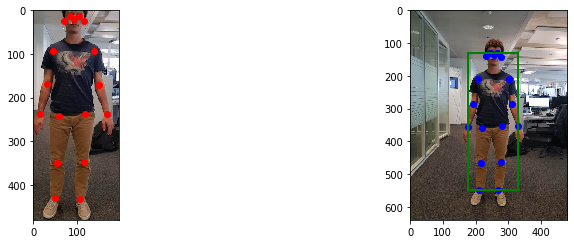

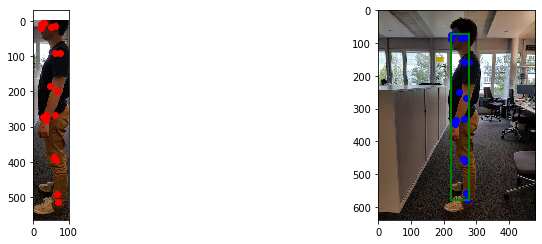

In [100]:
i=0
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [101]:
body_props_1, face_pos_1 = pose2d.get_proportions(front_view, side_view)

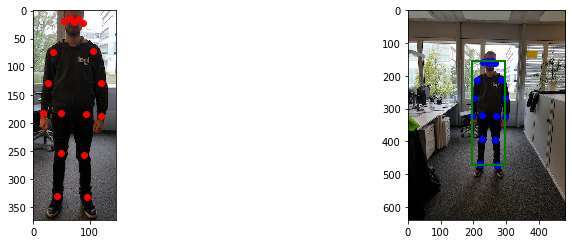

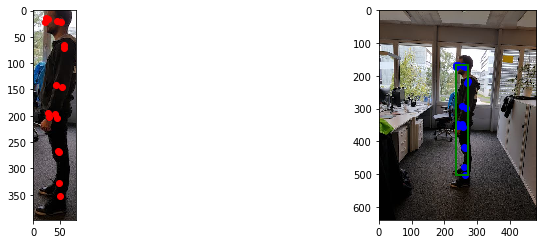

In [102]:
i=14
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [103]:
body_props_2, face_pos_2 = pose2d.get_proportions(front_view, side_view)

#### b- run the network on testing images

run pifpaf

In [51]:
! python3 -m openpifpaf.predict ./data/pifpaf/test_images/*  --force-complete-pose -o ./data/pifpaf/test_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [104]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/test_jsons/')

we loaded 15 pedestrians


In [123]:
pifpaf = [x for x in pifpaf if np.mean(x['confidence'])>0.2]

In [124]:
len(pifpaf)

12

In [111]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head']

##### actor 1

In [214]:
preds_1 = []

for i in range(2,len(pifpaf)):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_1.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_1.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_1.append(pred_pose)
    

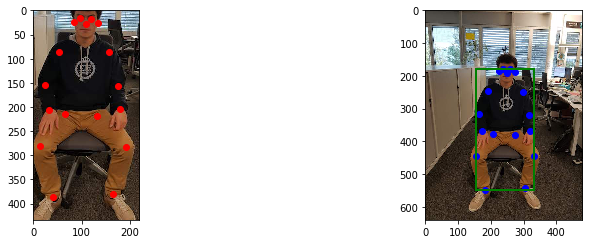

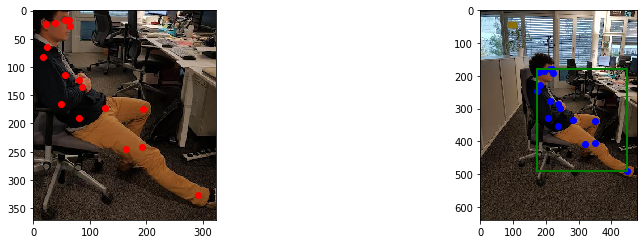

In [211]:
i,j = 0,5
vs.show_pp_on_image(pifpaf[i+2],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j+2],'./data/pifpaf/test_images/','.jpg')

In [204]:
go.Figure(vs.plot([preds_1[i],preds_1[j]]))

In [217]:
go.Figure(vs.plot(preds_1[5:]))

##### actor 2

In [205]:
preds_2 = []

for i in range(2):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_2.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_2.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_2, face_pos_2)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_2.append(pred_pose)
    

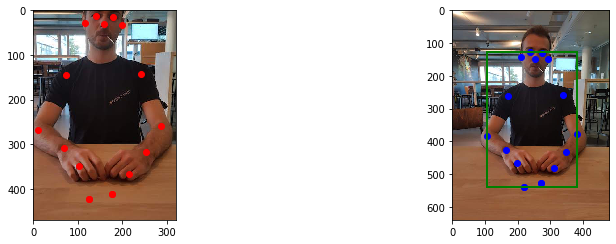

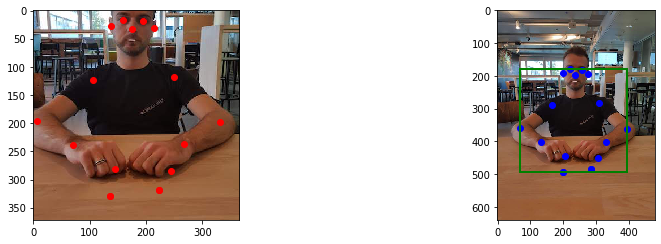

In [206]:
i,j = 0,1
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j],'./data/pifpaf/test_images/','.jpg')

In [207]:
go.Figure(vs.plot([preds_2[i],preds_2[j]]))